<a href="https://colab.research.google.com/github/BelalEbrahim/AI2-Project/blob/main/Startups_Success_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# 📚 Imports
!pip install folium
!pip install nltk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# 📖 Data
df = pd.read_csv('/content/startup data.csv')
print(df.info())
print(df.head())

# ⚙ Data Cleaning Suggestions
df.drop(['Unnamed: 6', 'Unnamed: 0', 'id', 'name', 'object_id', 'first_funding_at',
         'zip_code', 'city', 'founded_at', 'closed_at', 'age_last_milestone_year',
         'age_first_milestone_year', 'state_code.1',  'last_funding_at'], axis = 1, inplace = True)

# 🗑 Removing outliers
std_deviation = 2
mean = df['avg_participants'].mean()
std = df['avg_participants'].std()

upper_threshold = mean + (std_deviation * std)
lower_threshold = mean - (std_deviation * std)
df = df[(df['avg_participants'] >= lower_threshold) & (df['avg_participants'] <= upper_threshold)]

df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

,state_code,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,42.358880,-71.056820,1,2.2493,3.0027,3,3,375000,3,...,1,0,1,0,0,0,0,1.0000,0,acquired
1,CA,37.238916,-121.973718,1,5.1260,9.9973,9,4,40100000,1,...,0,1,0,0,1,1,1,4.7500,1,acquired
2,CA,32.901049,-117.192656,1,1.0329,1.0329,5,1,2600000,2,...,0,0,0,1,0,0,0,4.0000,1,acquired
3,CA,37.320309,-122.050040,1,3.1315,5.3151,5,3,40000000,1,...,0,0,0,0,1,1,1,3.3333,1,acquired
4,CA,37.779281,-122.419236,0,0.0000,1.6685,2,2,1300000,1,...,0,1,1,0,0,0,0,1.0000,1,closed


<ipython-input-19-383c3dfe982e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['status'], palette='viridis')


<Axes: xlabel='status', ylabel='count'>

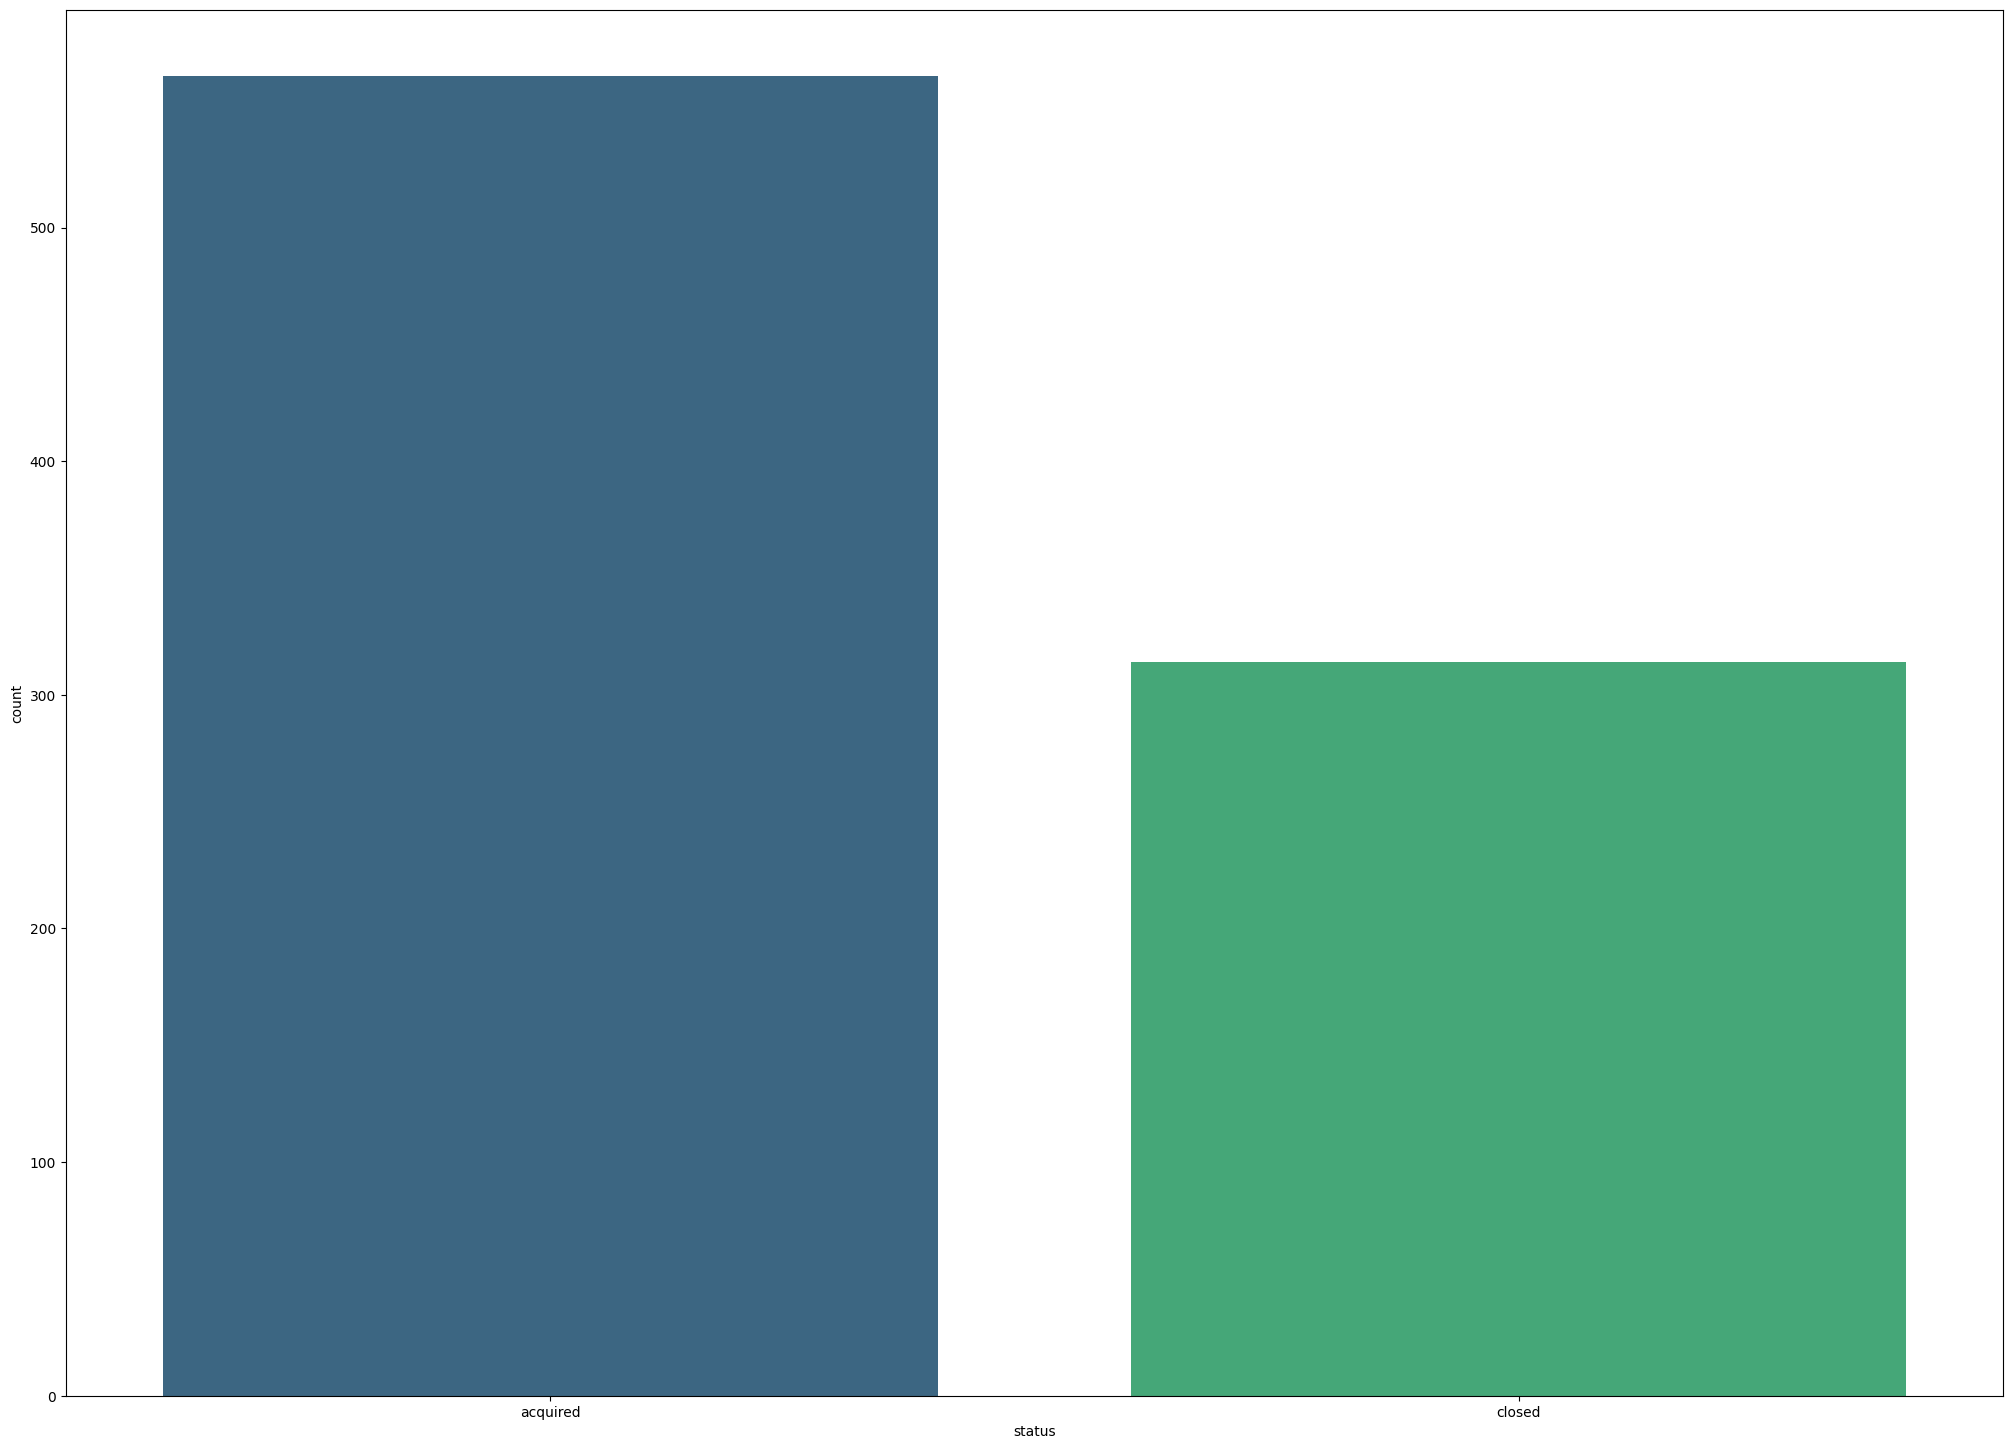

In [19]:
# 👀 Visualization
latitude_initial = 39.8283
longitude_initial = -50.0000

map = folium.Map(location=[latitude_initial, longitude_initial], zoom_start=3, tiles='cartodbpositron')
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['state_code']).add_to(map)

map

plt.figure(figsize=(25, 18))

sns.countplot(x=df['status'], palette='viridis')


In [20]:
# 🧬 Encoding Categorical Variables (with saved mappings)
list_str = df.select_dtypes(include='object').columns
label_encoders = {}  # Store encoders for each column

for col in list_str:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save the encoder

# 🗂️ Create label mappings dictionary
label_mappings = {}
for col, encoder in label_encoders.items():
    label_mappings[col] = {label: int(idx) for idx, label in enumerate(encoder.classes_)}

# 💾 Save mappings to JSON
import json
with open('label_mappings.json', 'w') as f:
    json.dump(label_mappings, f, indent=4)


# ✂ Feature Selection
X = df.drop(['status', 'latitude', 'longitude'], axis=1)
y = df['status']

# 🏋🏾‍♀ Splitting Data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=0)

# Training Models
lr = LogisticRegression()
lr.fit(xtrain, ytrain)
pred_lr = lr.predict(xtest)

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
pred_dt = dt.predict(xtest)

In [21]:
# 📋 Results
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

evaluate_model(ytest, pred_lr, "Logistic Regression")
evaluate_model(ytest, pred_dt, "Decision Tree")


Logistic Regression Results:
Accuracy: 0.6864
Precision: 0.6136
Recall: 0.3418
F1-Score: 0.4390

Decision Tree Results:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [22]:
# Single Example with Matching Features
example = {
    "age_first_funding_year": 2.0,
    "age_last_funding_year": 6.0,
    "relationships": 3,
    "funding_rounds": 4,
    "funding_total_usd": 15000000,
    "milestones": 2,
    "is_CA": 1,
    "is_NY": 0,
    "is_MA": 0,
    "is_TX": 0,
    "is_otherstate": 0,
    "is_software": 1,
    "is_web": 1,
    "is_mobile": 0,
    "is_enterprise": 0,
    "is_advertising": 0,
    "is_gamesvideo": 0,
    "is_ecommerce": 1,
    "is_biotech": 0,
    "is_consulting": 0,
    "is_othercategory": 0,
    "has_VC": 1,
    "has_angel": 1,
    "has_roundA": 1,
    "has_roundB": 0,
    "has_roundC": 0,
    "has_roundD": 0,
    "avg_participants": 1.5,
    "is_top500": 1,
    "labels": 1,  # Default value for labels
    "category_code": 0,  # Encoded value for category_code
    "state_code": 0  # Encoded value for state_code
}

# Ensure the example matches the training feature names and order
example_df = pd.DataFrame([example], columns=X.columns)

# Predicting the outcome
prediction = lr.predict(example_df)

print("\nSingle Example Prediction:")
print("Prediction:", "Success (Acquired)" if prediction[0] == 1 else "Failure (Closed)")


Single Example Prediction:
Prediction: Failure (Closed)


In [23]:
import joblib
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming df, X, and dt are already defined from your notebook
list_str = ['state_code', 'category_code']  # Categorical columns
label_encoders = {}
for col in list_str:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define X (features) and y (target) as in your notebook
X = df.drop(['status', 'latitude', 'longitude'], axis=1)
y = df['status']

# Save the LabelEncoders, feature names, and Decision Tree model
joblib.dump(label_encoders, 'label_encoders.joblib')
joblib.dump(X.columns, 'feature_names.joblib')
joblib.dump(dt, 'decision_tree_model.joblib')

['decision_tree_model.joblib']